In [ ]:
# Import libraries for image processing and plotting
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread  # we read images with skimage.io.imread
from skimage.morphology import area_closing, area_opening

# list of example image paths (relative to this notebook)
images = [
    "../../data/vehicle-type-detection/motorcycle/PIC_0.jpg",
    "../../data/vehicle-type-detection/pickup/PIC_1.jpg",
    "../../data/vehicle-type-detection/suv/PIC_2.jpg",
]


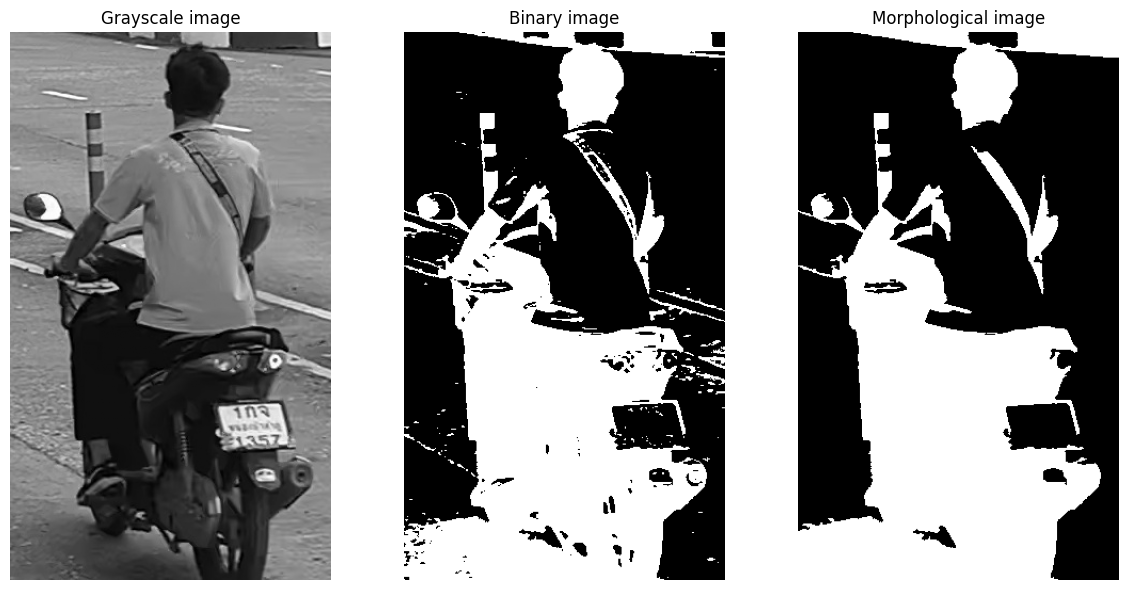

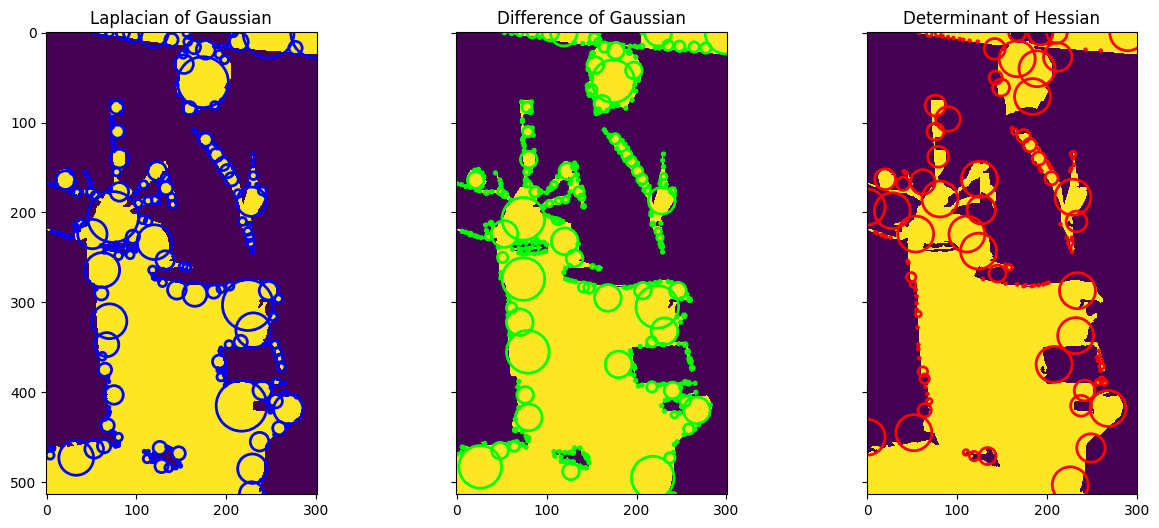

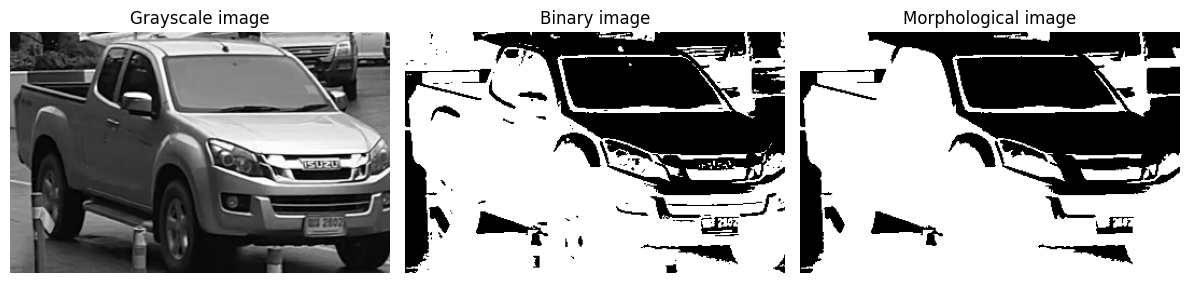

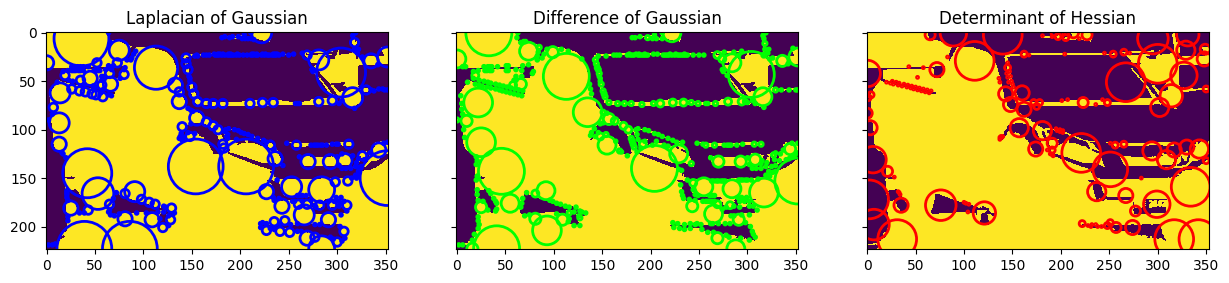

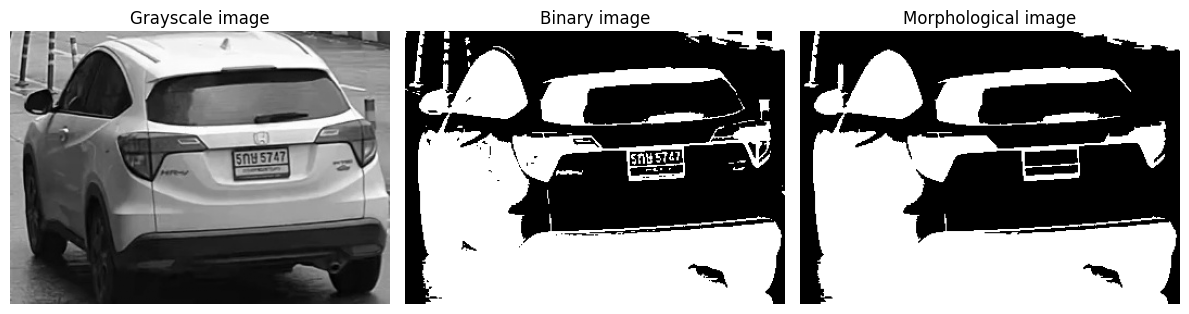

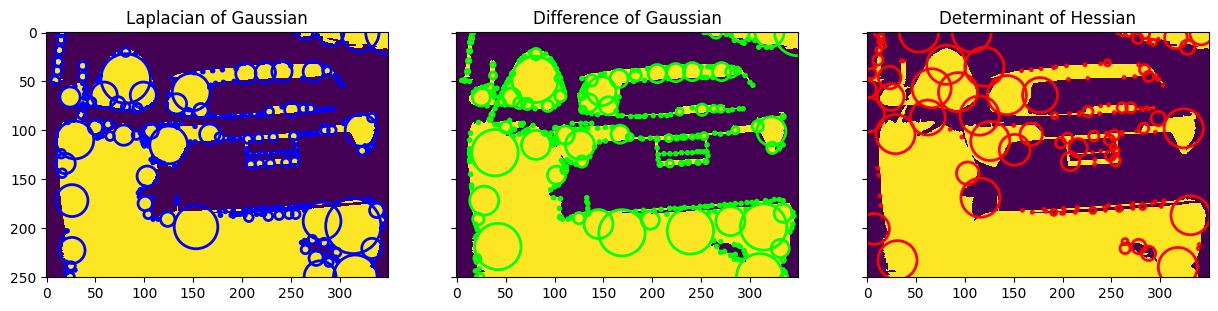

In [ ]:
# Blob detection and simple statistics for each image

threshold = 0.4  # binarization threshold (lower => more foreground)
stats = []  # collect summary statistics per image/method

for url in images:
    # --- load and preprocess -------------------------------------------------
    im = rgb2gray(imread(url))  # convert image to grayscale
    binary_im = im < threshold   # simple thresholding to binary image

    # --- morphological cleaning ---------------------------------------------
    # remove small holes/objects with area opening/closing (200-pixel threshold)
    morph_image = area_closing(area_opening(binary_im, 200), 200)

    # --- show the grayscale, binary and morphological images -----------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(im, cmap='gray')
    axes[0].set_title('Grayscale image')
    axes[0].axis('off')

    axes[1].imshow(binary_im, cmap='gray')
    axes[1].set_title('Binary image')
    axes[1].axis('off')

    axes[2].imshow(morph_image, cmap='gray')
    axes[2].set_title('Morphological image')
    axes[2].axis('off')

    plt.tight_layout(); plt.show()

    # --- blob detection (three methods) ------------------------------------
    # blob_log and blob_dog return sigma in column 2; convert to plotted radius
    blobs_log = blob_log(morph_image, max_sigma=20, num_sigma=10, threshold=.1)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    blobs_dog = blob_dog(morph_image, max_sigma=20, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

    # blob_doh returns approximate radius already in column 2
    blobs_doh = blob_doh(morph_image, max_sigma=20, threshold=.01)

    # prepare lists for plotting and stats
    blob_lists = [blobs_log, blobs_dog, blobs_doh]
    colors = ['blue', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
    axis = axes.ravel()

    for idx, (blobs, color, title) in enumerate(zip(blob_lists, colors, titles)):
        # set title and show the preprocessed image
        axis[idx].set_title(title)
        axis[idx].imshow(morph_image, interpolation='nearest')

        # draw a circle for each detected blob (x,y,radius)
        for blob in blobs:
            y, x, r = blob
            circle = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            axis[idx].add_patch(circle)

        # compute simple summary statistics for this method
        if len(blobs) > 0:
            y = blobs[:, 0]
            x = blobs[:, 1]
            r = blobs[:, 2]

            n_blobs = len(blobs)
            mean_r, std_r = np.mean(r), np.std(r)
            mean_x, std_x = np.mean(x), np.std(x)
            mean_y, std_y = np.mean(y), np.std(y)
        else:
            # no blobs detected => use zeros/nan for stats
            n_blobs = 0
            mean_r = std_r = mean_x = std_x = mean_y = std_y = np.nan

        # append a dictionary with summary values for this image and method
        stats.append({
            'image': url.split('/')[-1],
            'method': title,
            'n_blobs': n_blobs,
            'mean_r': mean_r,
            'std_r': std_r,
            'mean_x': mean_x,
            'std_x': std_x,
            'mean_y': mean_y,
            'std_y': std_y
        })

        axis[idx].set_axis_off()

    plt.tight_layout()
    plt.show()


In [ ]:
# Statistics for each image and method
# build a pandas DataFrame from the collected stats and display it
import pandas as pd

df = pd.DataFrame(stats)
display(df)


,image,method,n_blobs,mean_r,std_r,mean_x,std_x,mean_y,std_y
0,PIC_0.jpg,Laplacian of Gaussian,273,4.366967,5.308134,137.362637,75.055074,251.897436,145.060189
1,PIC_0.jpg,Difference of Gaussian,354,3.230228,4.242686,143.796610,74.690725,239.435028,143.479176
2,PIC_0.jpg,Determinant of Hessian,133,5.968254,6.923292,146.601504,80.372810,220.676692,132.869915
3,PIC_1.jpg,Laplacian of Gaussian,380,3.197694,4.389458,184.289474,101.790680,98.571053,67.046313
4,PIC_1.jpg,Difference of Gaussian,452,2.469354,3.381427,185.626106,104.937274,103.387168,65.388005
5,PIC_1.jpg,Determinant of Hessian,155,4.759140,5.599721,164.219355,99.778288,89.174194,60.940812
6,PIC_2.jpg,Laplacian of Gaussian,290,3.493812,4.501606,179.424138,96.389312,118.031034,61.387203
7,PIC_2.jpg,Difference of Gaussian,346,3.010466,4.147369,168.606936,101.124866,110.427746,63.782884
8,PIC_2.jpg,Determinant of Hessian,145,5.091188,6.307660,199.855172,98.609294,98.062069,66.270836
